# Pytorch多层神经网络—分类MNIST手写数字数据集

>同济大学 张子豪 2019-12-05<br>

<div class="alert alert-block alert-info">
Shift + Enter 运行单元格中的代码<br>
双击单元格进入编辑模式，即可修改代码。<br>
</div>
关于Jupyter notebook的基本操作、快捷键，请看这个视频：

[Jupyter notebook快速入门](https://www.bilibili.com/video/av54100790)

![jupyter](http://jupyter.org/assets/main-logo.svg)


![](img/pytorch.jpg)


# 接下来你将做什么

本案例，你将使用Pytorch搭建多层感知机神经网络（MLP），对著名的手写数字数据集MNIST的七万张图片进行分类，包含完整的多层感知机模型定义、损失函数、优化器超参数设置、梯度下降与反向传播训练神经网络、可视化训练过程的误差下降，用测试集的一万张图片进行模型评估，并**分析被分类错误的图片具有哪些特征，神经网络为什么会将这些图片分类错误？哪些图片最容易被错分类？最容易被错分到哪一类？**

MNIST手写数字数据集介绍

请看Bilibili视频：[【子豪兄】玩转MNIST数据集](https://www.bilibili.com/video/av77162901/)

![](img/MNIST.jpg)

# 1.导入工具库

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

# 2.设定超参数

In [2]:
# 查看你的电脑是否支持gpu加速,就算返回False也没关系
torch.cuda.is_available()

False

In [3]:
# 有gpu就用gpu，没有就用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [4]:
device

device(type='cpu')

In [5]:
input_size = 784 # 输入数据的维度，28*28=784
hidden_size = 128 # 隐含层神经元个数
num_classes = 10 # 输出层神经元个数，每个神经元对应一类的概率
num_epochs = 5 # 迭代轮次，完整处理完训练集中所有的数据是一轮
batch_size = 100 # 每一批数据大小，一口一口喂给神经网络
learning_rate = 0.001 # 学习率

我们将构建包含一个隐含层的多层感知机(全连接多层神经网络)，输入为784维的数据，隐含层128个神经元，输出层10个神经元，分别输出图片在0-9十个分类上的概率。

下图展示了两个隐含层多层感知机神经网络的基本架构，我们构建的神经网络只包含一个隐含层，与动图中稍有不同

![](img/mlp2.gif)

![多层感知机](img/mlp1.png)

# 3.导入数据集

In [6]:
# 载入MNIST手写数字数据集
# 载入训练集
train_dataset = torchvision.datasets.MNIST(root='./dataset', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)
# 载入测试集
test_dataset = torchvision.datasets.MNIST(root='./dataset',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader构建输入数据加载器，这个加载器是一个python生成器，可以认为是一个流水线，每次都返回一批新数据
# 训练集数据载入流水线
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# 测试集数据载入流水线
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## 可视化数据

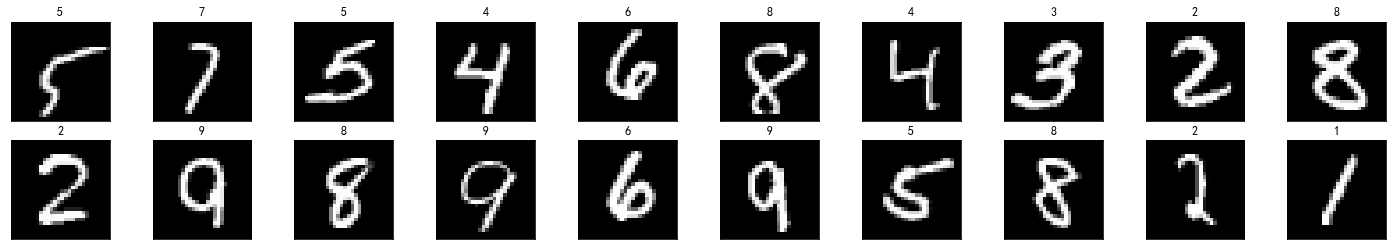

In [7]:
# 可重复运行，展示不同的图片

# 构造迭代器，获得训练集中的一批次数据
dataiter = iter(train_loader)
images, labels = dataiter.next()
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

# 可视化图片和标签
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # .item()获取张量的数值
    ax.set_title(str(labels[idx].item()))

Text(0.5, 1.0, 'label:7')

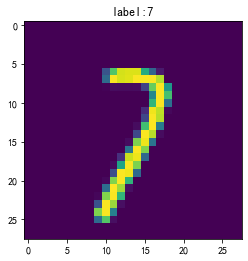

In [11]:
plt.imshow(images[1][0])
plt.title('label:'+str(labels[1].item()))

## 展示图像的像素细节

In [12]:
images[1].shape

(1, 28, 28)

In [13]:
np.squeeze(images[1]).shape

(28, 28)

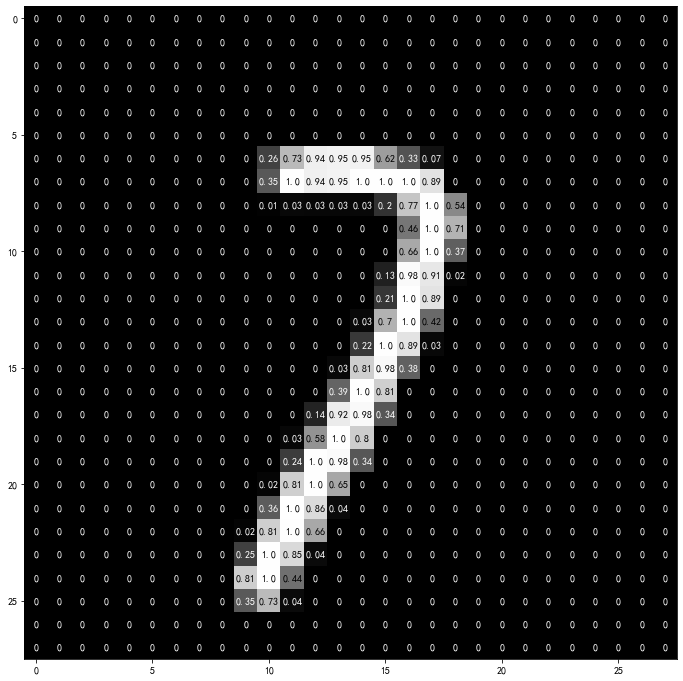

In [14]:
# 去掉图像的批次维度，只保留索引为1的单张图像的长宽像素值
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5

# 遍历每一行每一列每一个像素
for x in range(width):
    for y in range(height):
        # 像素值保留两位小数，如果为0则显示0
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# 4.构建模型、定义损失与优化器

In [15]:
# 添加隐层，构建多层感知器
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # 定义输入层到隐含层
        self.relu = nn.ReLU() # 定义隐含层的激活函数为Relu激活函数
        self.fc2 = nn.Linear(hidden_size, num_classes)  # 定义隐含层到输出层
    
    def forward(self, x):
        out = self.fc1(x) # 数据从输入经过隐含层
        out = self.relu(out) # 隐含层Relu激活函数激活
        out = self.fc2(out) # 数据从隐含层到输出层
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# 多分类问题使用交叉熵损失，使用Adam优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

# 5.模型训练

In [16]:
len(train_loader)

600

In [17]:
# 训练模型 每打印一次调试信息表示过了一万张图片 （每步批次100张图片，每100步打印一次调试信息）
# 每一轮 = 六万张图片 = 100*600步 = 100*100*6次打印调试信息
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # 转到gpu设备上
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # 前向运算
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('目前总轮次进程 [{}/{}], 当前批次进程 [{}/{}], 当前损失: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

目前总轮次进程 [1/5], 当前批次进程 [100/600], 当前损失: 0.2962
目前总轮次进程 [1/5], 当前批次进程 [200/600], 当前损失: 0.3013
目前总轮次进程 [1/5], 当前批次进程 [300/600], 当前损失: 0.3463
目前总轮次进程 [1/5], 当前批次进程 [400/600], 当前损失: 0.3668
目前总轮次进程 [1/5], 当前批次进程 [500/600], 当前损失: 0.1054
目前总轮次进程 [1/5], 当前批次进程 [600/600], 当前损失: 0.3015
目前总轮次进程 [2/5], 当前批次进程 [100/600], 当前损失: 0.1056
目前总轮次进程 [2/5], 当前批次进程 [200/600], 当前损失: 0.2076
目前总轮次进程 [2/5], 当前批次进程 [300/600], 当前损失: 0.1772
目前总轮次进程 [2/5], 当前批次进程 [400/600], 当前损失: 0.1409
目前总轮次进程 [2/5], 当前批次进程 [500/600], 当前损失: 0.1405
目前总轮次进程 [2/5], 当前批次进程 [600/600], 当前损失: 0.0488
目前总轮次进程 [3/5], 当前批次进程 [100/600], 当前损失: 0.1891
目前总轮次进程 [3/5], 当前批次进程 [200/600], 当前损失: 0.1833
目前总轮次进程 [3/5], 当前批次进程 [300/600], 当前损失: 0.1811
目前总轮次进程 [3/5], 当前批次进程 [400/600], 当前损失: 0.1982
目前总轮次进程 [3/5], 当前批次进程 [500/600], 当前损失: 0.0787
目前总轮次进程 [3/5], 当前批次进程 [600/600], 当前损失: 0.0470
目前总轮次进程 [4/5], 当前批次进程 [100/600], 当前损失: 0.1051
目前总轮次进程 [4/5], 当前批次进程 [200/600], 当前损失: 0.0498
目前总轮次进程 [4/5], 当前批次进程 [300/600], 当前损失: 0.0899
目前总轮次进程 [4/5], 当前批次进程 [400/600], 当

# 6.预估与测试集评估

In [18]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('10000张测试图片上的准确率为 {} %'.format(100 * correct / total))

# 模型存储
torch.save(model.state_dict(), './mlp.ckpt')

10000张测试图片上的准确率为 97 %


# 7.增加可视化内容，重新训练和评估，分析分类错误的图片

In [19]:
# 重新训练 绘制错误率曲线 画出分类错误的图片
# 训练模型 

model = NeuralNet(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

loss_list = [] # 每1步存储一次损失值
loss_list2 = [] # 每100步存储一次损失值
total_step = len(train_loader)
print('开始在训练集上训练')
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # 转到gpu设备上
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # 前向运算
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 每100步输出一次，每输出一次表示过了一万张图片 （每步，也就是每批次包含100张图片，每100步输出一次调试信息）
        if (i+1) % 100 == 0:
            loss_list2.append(loss.item())
            print ('目前总轮次进程 [{}/{}], 当前批次进程 [{}/{}], 当前损失: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

开始在训练集上训练
目前总轮次进程 [1/5], 当前批次进程 [100/600], 当前损失: 0.3789
目前总轮次进程 [1/5], 当前批次进程 [200/600], 当前损失: 0.4286
目前总轮次进程 [1/5], 当前批次进程 [300/600], 当前损失: 0.2621
目前总轮次进程 [1/5], 当前批次进程 [400/600], 当前损失: 0.1690
目前总轮次进程 [1/5], 当前批次进程 [500/600], 当前损失: 0.1773
目前总轮次进程 [1/5], 当前批次进程 [600/600], 当前损失: 0.1454
目前总轮次进程 [2/5], 当前批次进程 [100/600], 当前损失: 0.1787
目前总轮次进程 [2/5], 当前批次进程 [200/600], 当前损失: 0.0966
目前总轮次进程 [2/5], 当前批次进程 [300/600], 当前损失: 0.2206
目前总轮次进程 [2/5], 当前批次进程 [400/600], 当前损失: 0.1746
目前总轮次进程 [2/5], 当前批次进程 [500/600], 当前损失: 0.0990
目前总轮次进程 [2/5], 当前批次进程 [600/600], 当前损失: 0.0498
目前总轮次进程 [3/5], 当前批次进程 [100/600], 当前损失: 0.1425
目前总轮次进程 [3/5], 当前批次进程 [200/600], 当前损失: 0.0892
目前总轮次进程 [3/5], 当前批次进程 [300/600], 当前损失: 0.1273
目前总轮次进程 [3/5], 当前批次进程 [400/600], 当前损失: 0.1127
目前总轮次进程 [3/5], 当前批次进程 [500/600], 当前损失: 0.1145
目前总轮次进程 [3/5], 当前批次进程 [600/600], 当前损失: 0.0775
目前总轮次进程 [4/5], 当前批次进程 [100/600], 当前损失: 0.1324
目前总轮次进程 [4/5], 当前批次进程 [200/600], 当前损失: 0.0767
目前总轮次进程 [4/5], 当前批次进程 [300/600], 当前损失: 0.0705
目前总轮次进程 [4/5], 当前批次进程 [4

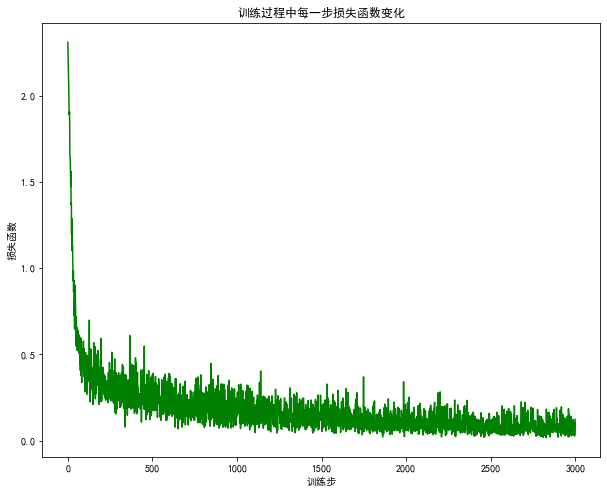

In [20]:
# 绘制训练过程中每一步的损失函数值
# 每一步，也就是每一批次，训练时用了100张图片
# 每一个epoch（训练集六万张图片）需要600步，5个epoch需要3000步，所以横坐标到3000
plt.figure(figsize=(10, 8))
plt.plot(loss_list,'g-')
plt.xlabel('训练步')
plt.ylabel('损失函数')
plt.title('训练过程中每一步损失函数变化')
plt.show()

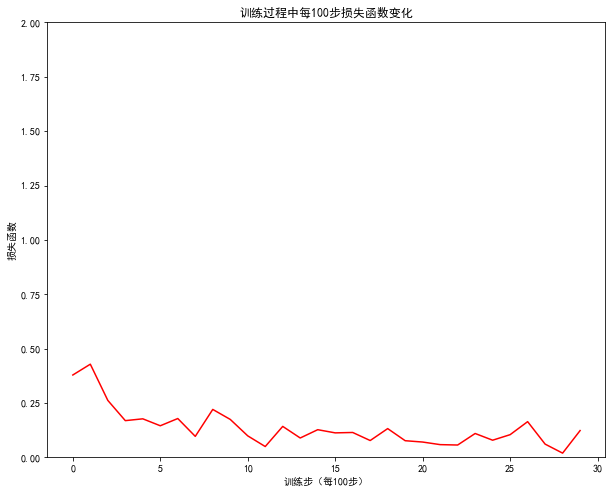

In [21]:
# 每100步的训练函数下降曲线
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 8))
plt.plot(loss_list2,'r-')
plt.ylim((0,2))
plt.xlabel('训练步（每100步）')
plt.ylabel('损失函数')
plt.title('训练过程中每100步损失函数变化')
plt.show()

In [22]:
# 在测试集的一万张图片上做测试，并存储分类错误的图片、它们对应的真实标签和预测结果
with torch.no_grad():
    correct = 0
    total = 0
    # 构建三个空列表，用于存放被分类错误的图片，以及对应的真实标签和预测结果
    wrong_image = [] # 用于存放被分类错误的图片
    wrong_image_label = [] # 用于存放被分类错误的图片的真实标签
    wrong_image_pred = []  # 用于存放被分类错误的图片的错误预测结果
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
        # 找出分类错误的图片，以及对应的真实标签和预测结果，分别放在三个列表里
        pred_result = np.argmax(outputs.numpy(),axis=1) # 找到模型推断的每张图片所属的类别
        labels = labels.numpy() # 将标签转为numpy的array数组
        final = (pred_result == labels) # 被分类正确的为True，被分类错误的为False
        wrong_index = np.where(final==False)[0] # 获取被分类错误的图片索引号
        
        for i in range(images[wrong_index].shape[0]):
            wrong_image.append(images[wrong_index][i]) # 存储被分类错误的图片
            wrong_image_label.append(labels[wrong_index][i]) # 存储被分类错误的图片对应的真实标签
            wrong_image_pred.append(pred_result[wrong_index][i]) # 存储被分类错误的图片的错误预测结果

    print('10000张测试图片上的准确率为 {} %'.format(100 * correct / total))
    print('有{}张图片被分类错误'.format(len(wrong_image_label)))

10000张测试图片上的准确率为 97 %
有286张图片被分类错误


In [33]:
images.shape

torch.Size([100, 784])

In [38]:
images[wrong_index].shape

torch.Size([4, 784])

In [39]:
wrong_index

array([ 4,  5, 44, 82], dtype=int64)

In [23]:
images[wrong_index].shape[0]

4

In [40]:
images[wrong_index][0].shape

torch.Size([784])

In [41]:
images[wrong_index][1].shape

torch.Size([784])

In [42]:
images[wrong_index][2].shape

torch.Size([784])

In [43]:
images[wrong_index][3].shape

torch.Size([784])

In [44]:
# 模型推断的类别
pred_result

array([8, 9, 0, 1, 0, 7, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7, 8, 6,
       4, 1, 9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3,
       8, 9, 1, 4, 0, 6, 1, 0, 0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3,
       6, 8, 7, 1, 5, 2, 4, 9, 4, 3, 6, 4, 1, 7, 2, 6, 6, 0, 1, 2, 3, 4,
       5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [45]:
# 实际的类别
labels

array([8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7, 8, 6,
       4, 1, 9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3,
       3, 9, 1, 4, 0, 6, 1, 0, 0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3,
       6, 8, 7, 1, 5, 2, 4, 9, 4, 3, 6, 4, 1, 7, 2, 6, 5, 0, 1, 2, 3, 4,
       5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [46]:
final

array([ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [47]:
len(wrong_image)

286

In [48]:
len(wrong_image_label)

286

In [49]:
len(wrong_image_pred)

286

真实类别: 8
模型猜测的类别: 4


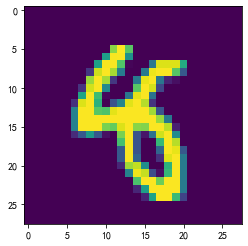

In [50]:
# 可视化分类错误图片中索引为i的图像，打印它的真实类别、模型猜测的类别
i = 3
plt.imshow(wrong_image[i].reshape(28,28))
print('真实类别:',wrong_image_label[i])
print('模型猜测的类别:',wrong_image_pred[i])

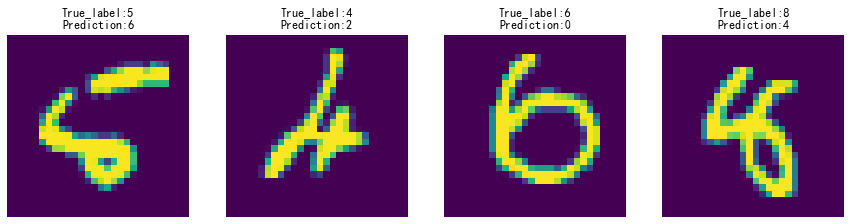

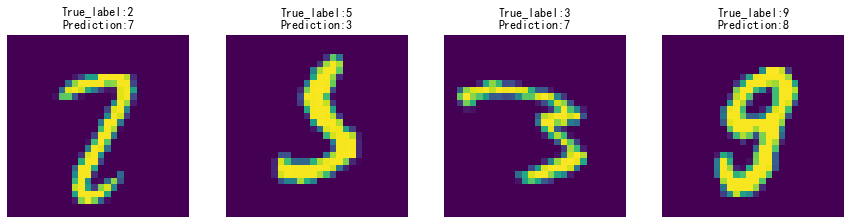

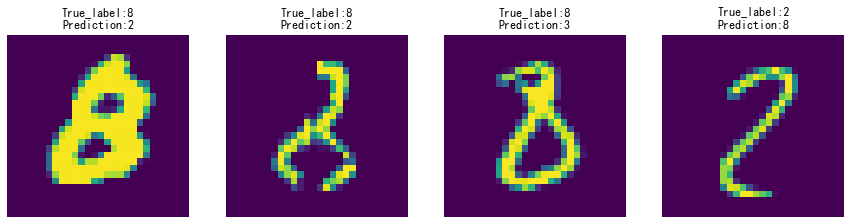

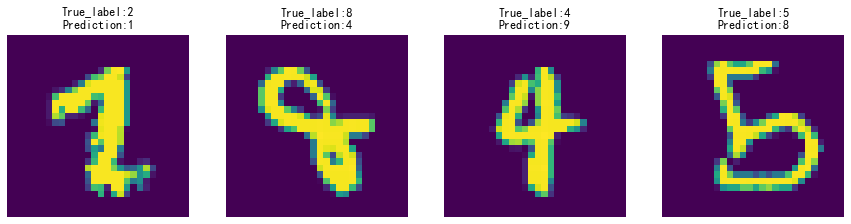

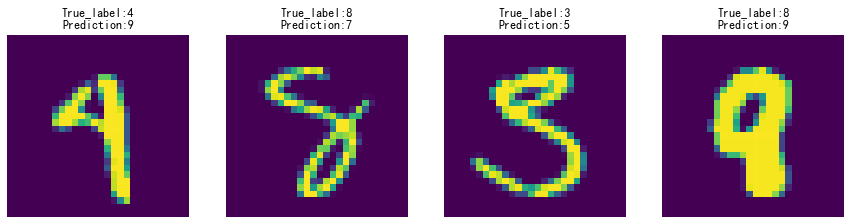

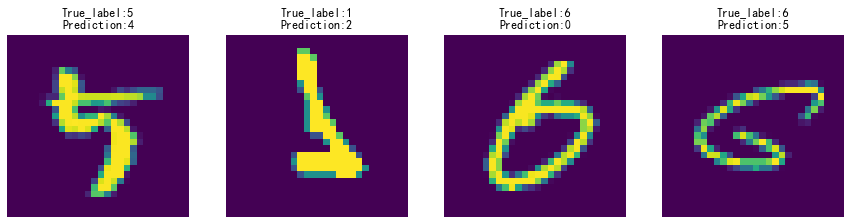

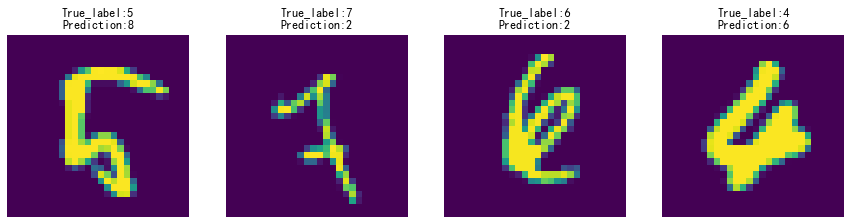

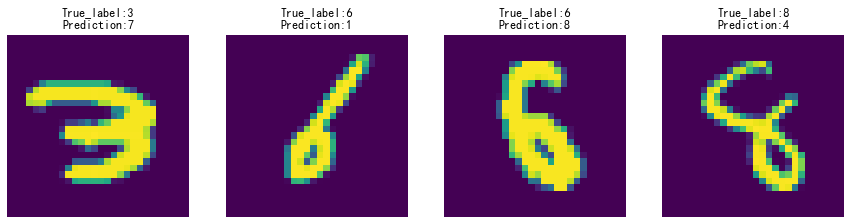

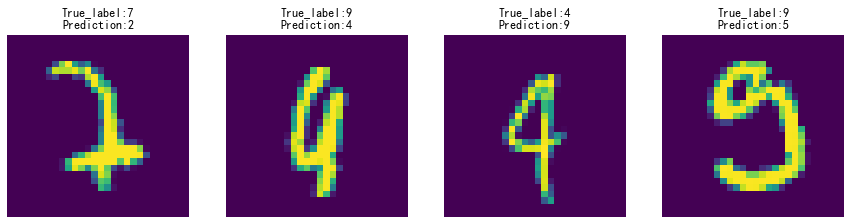

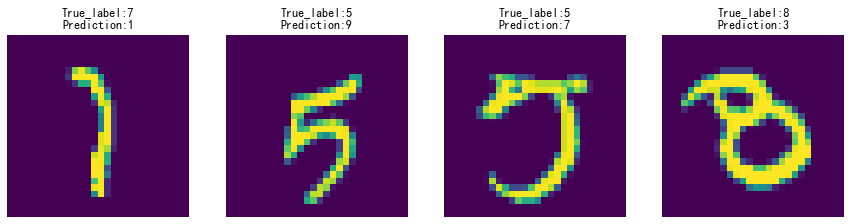

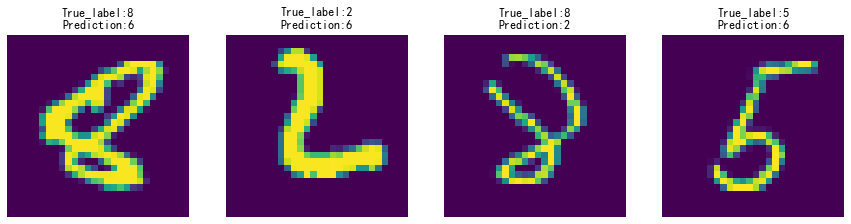

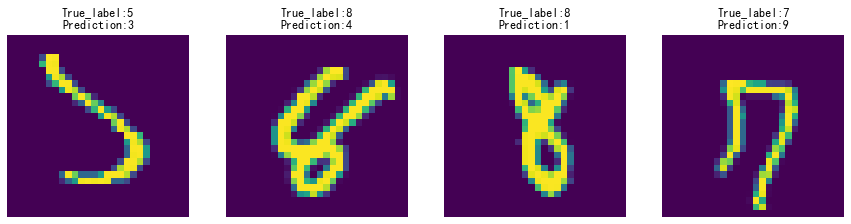

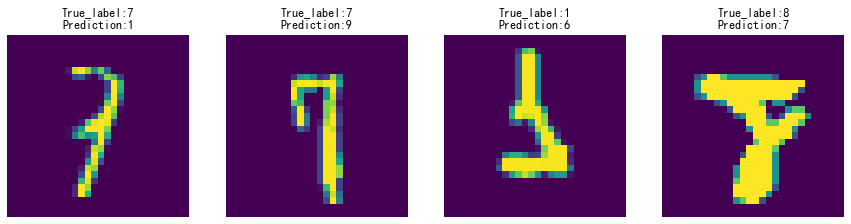

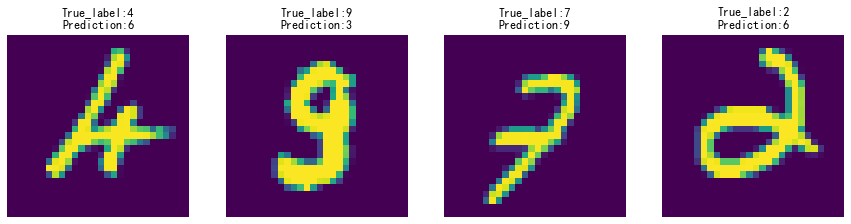

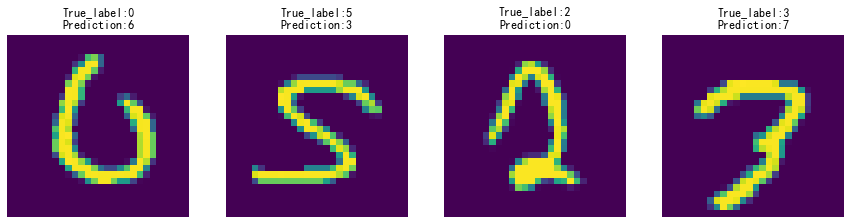

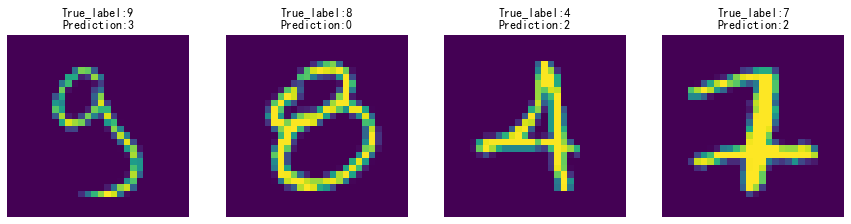

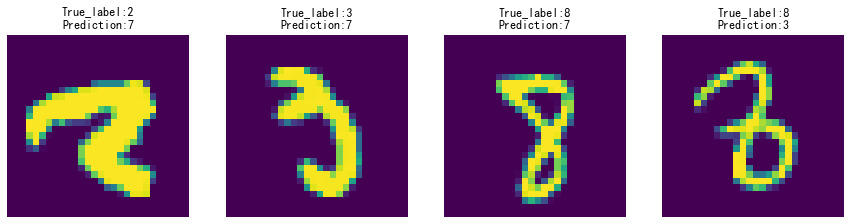

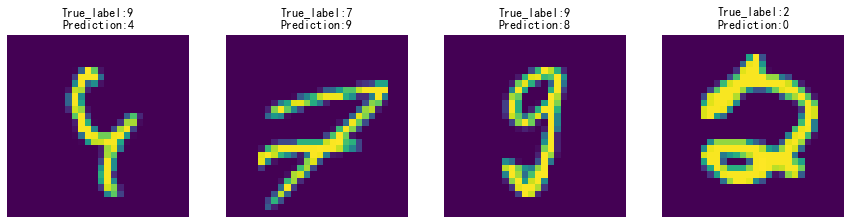

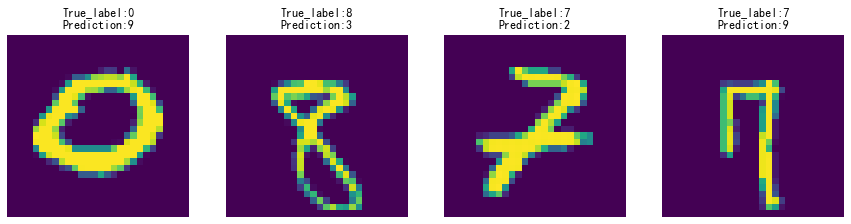

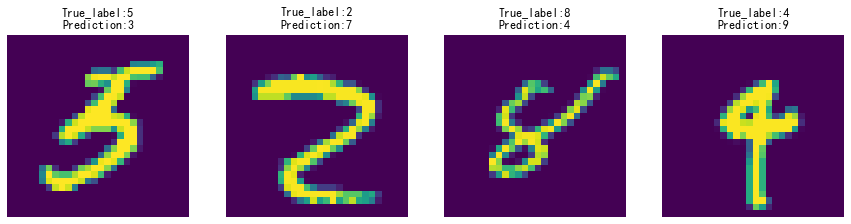

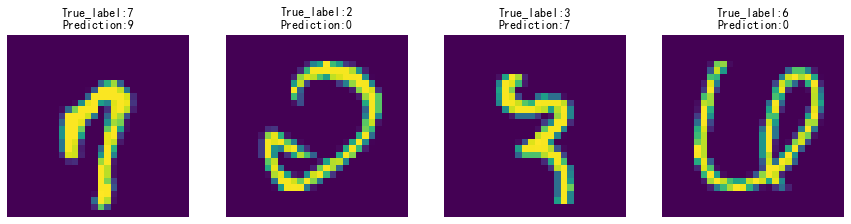

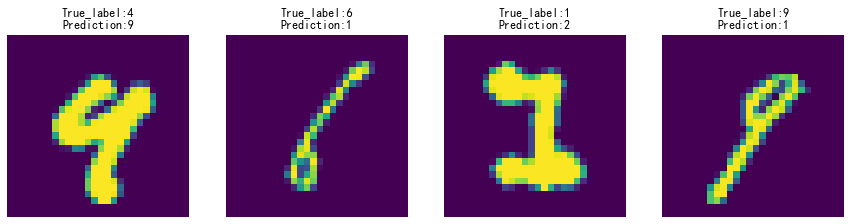

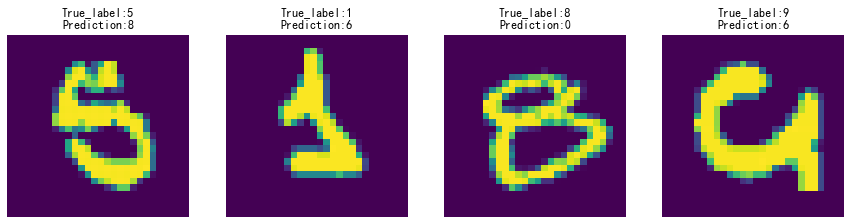

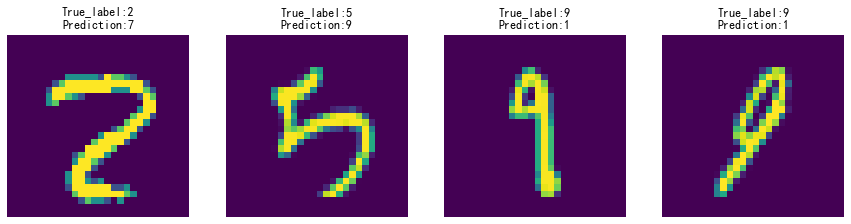

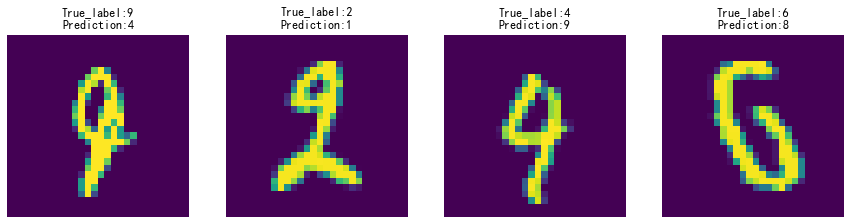

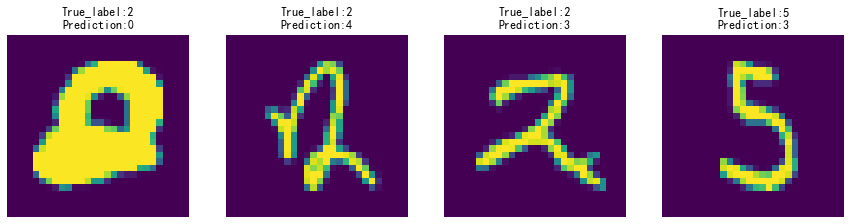

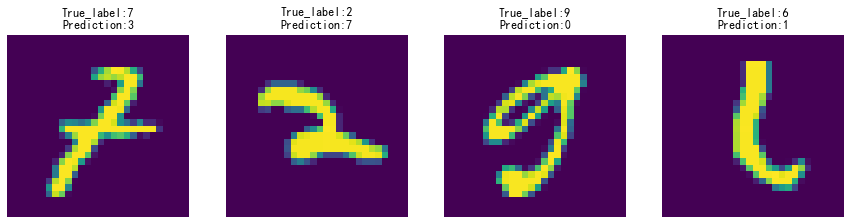

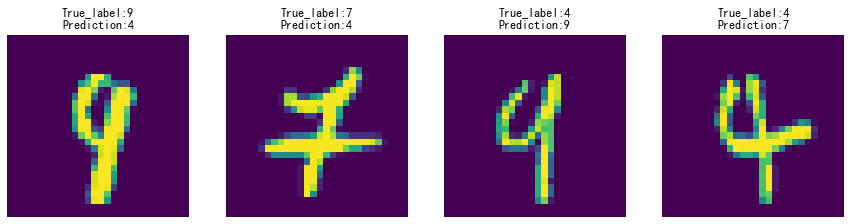

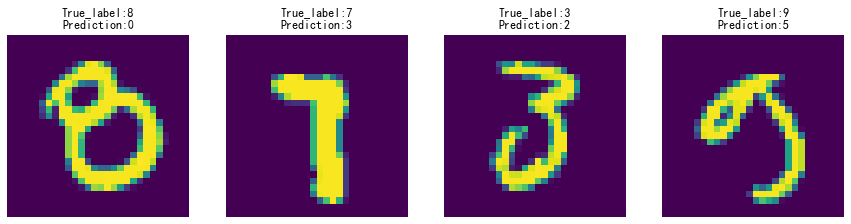

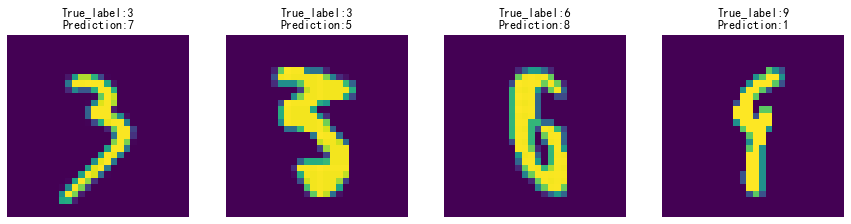

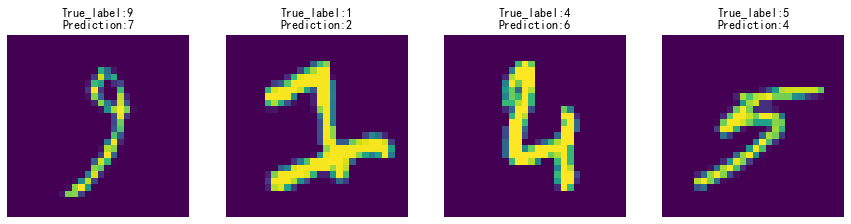

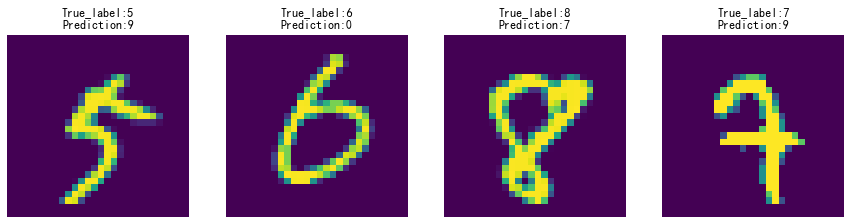

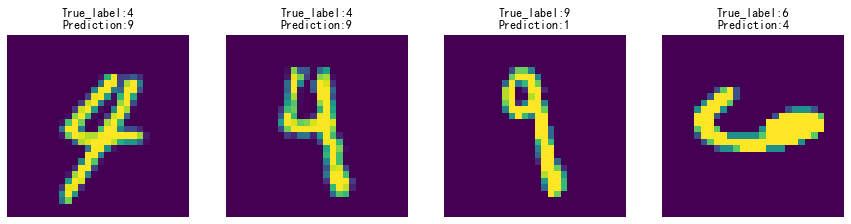

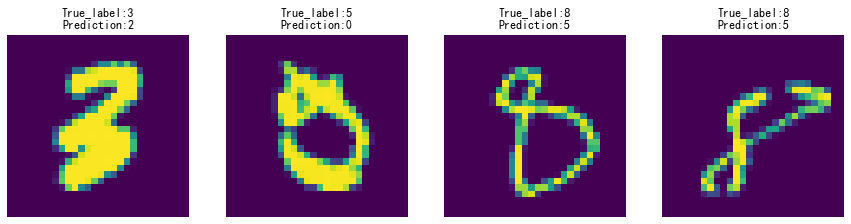

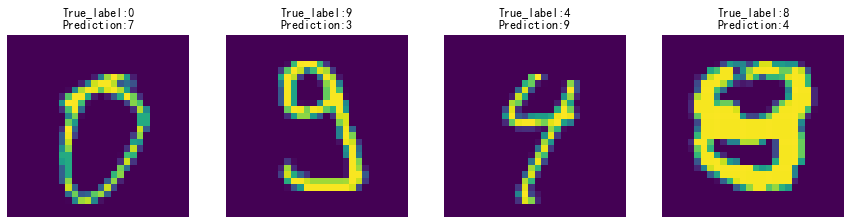

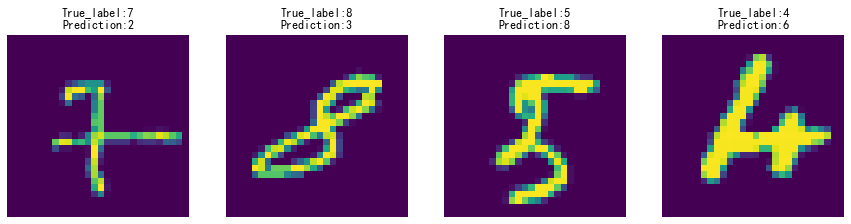

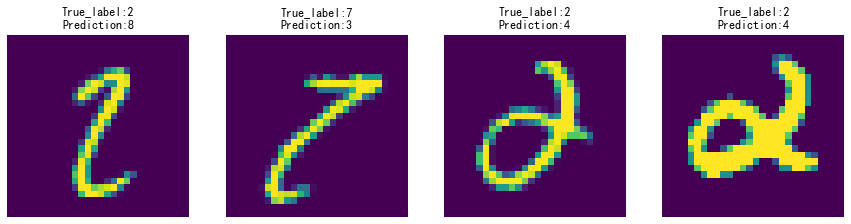

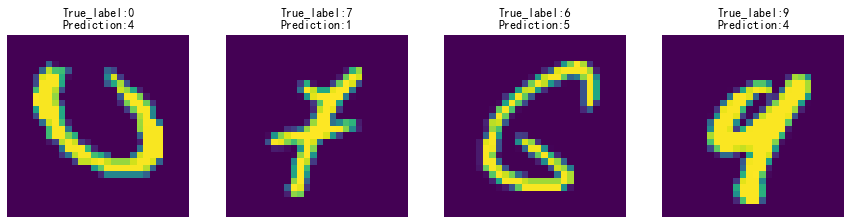

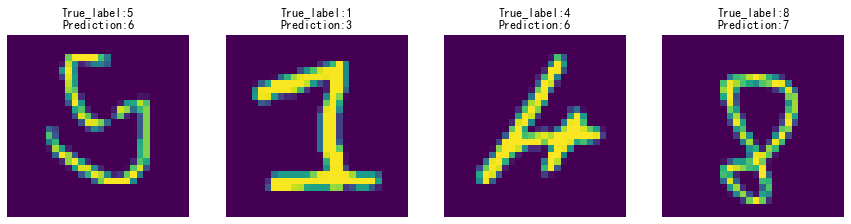

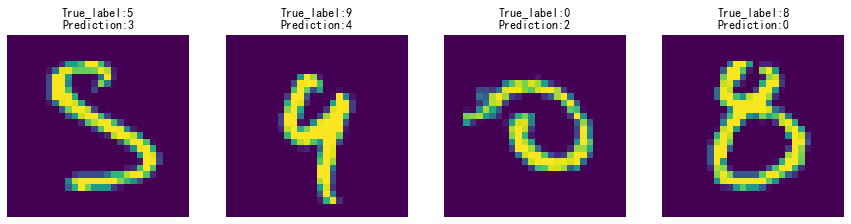

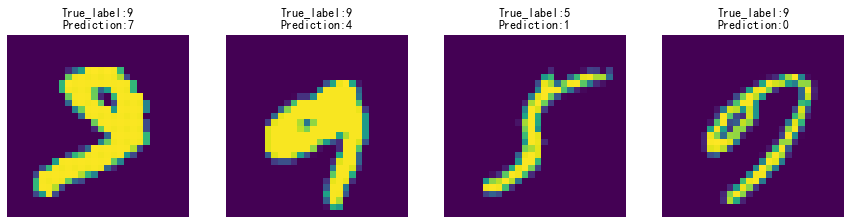

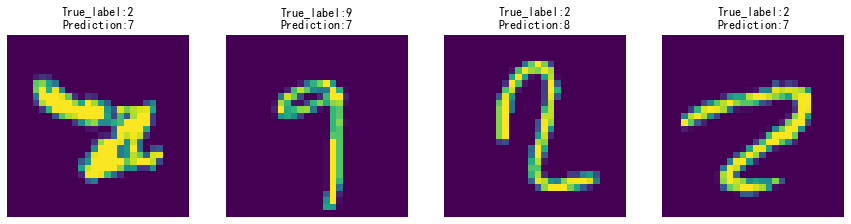

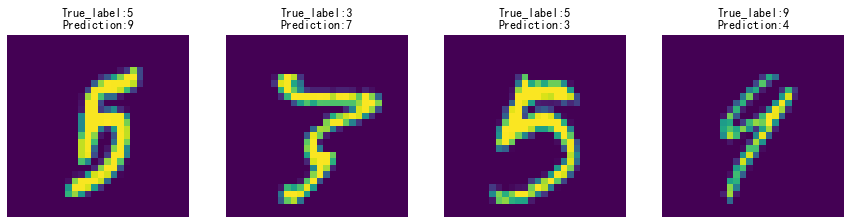

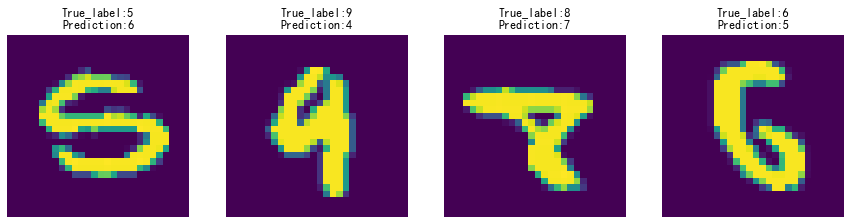

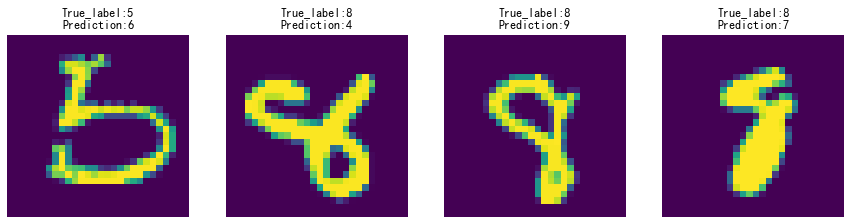

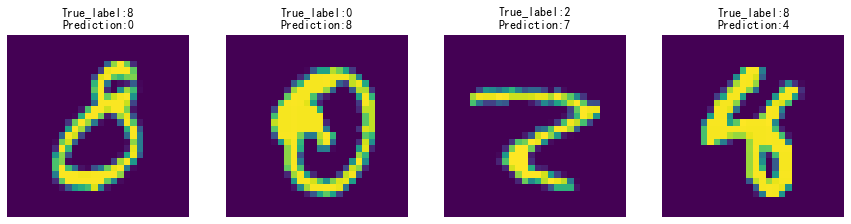

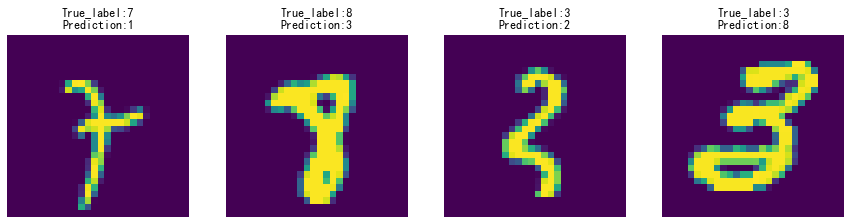

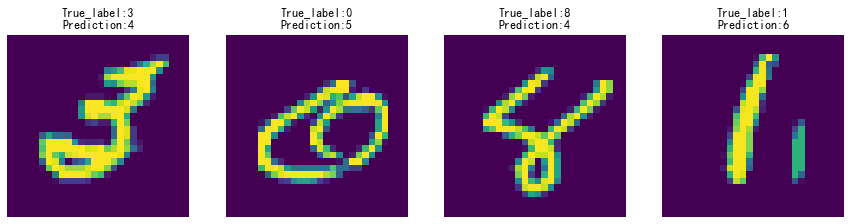

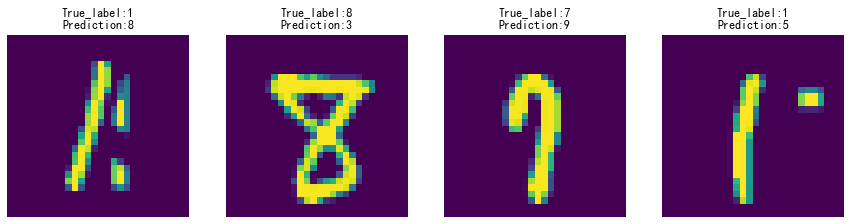

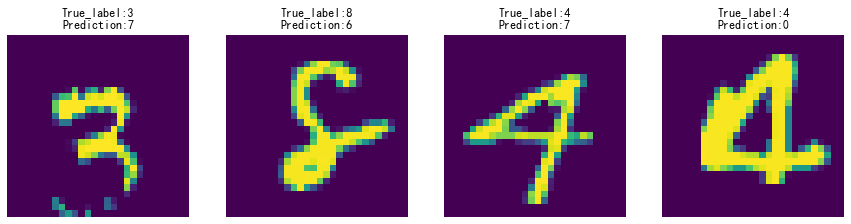

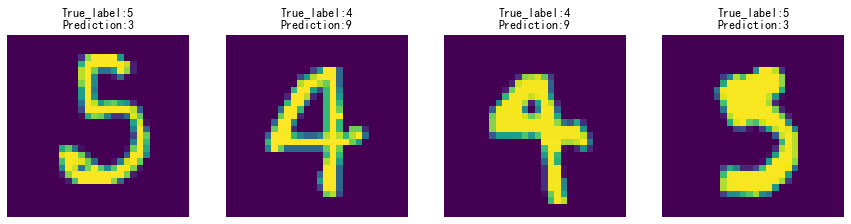

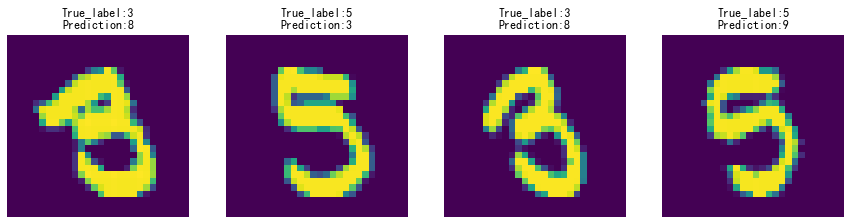

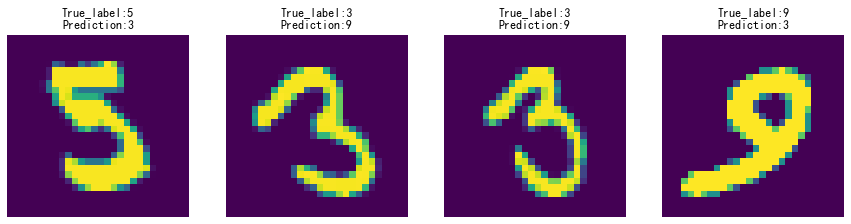

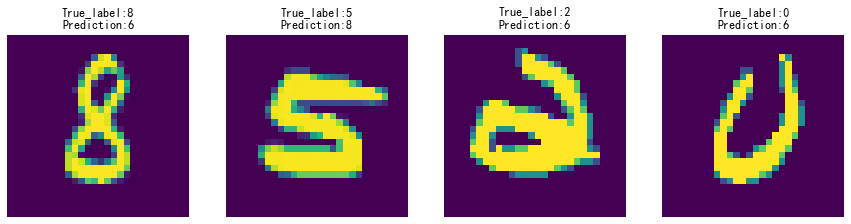

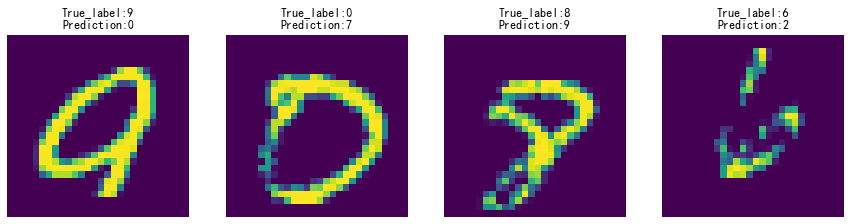

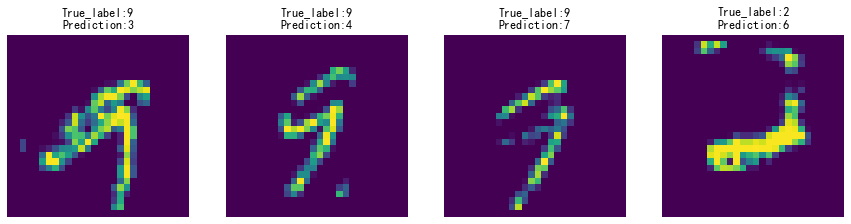

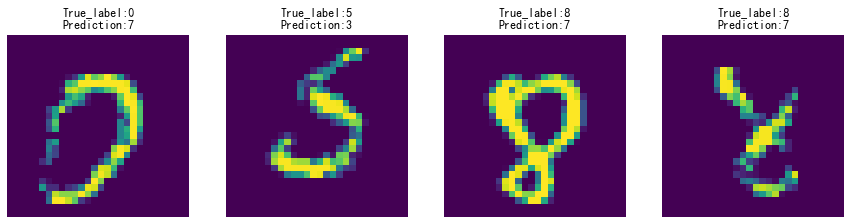

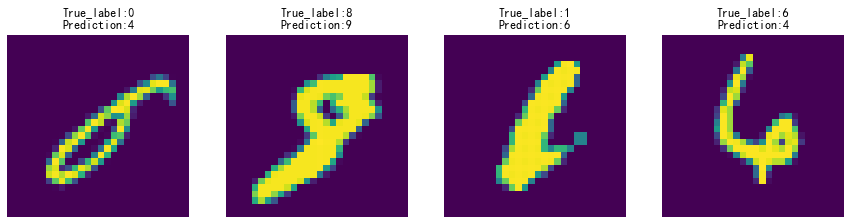

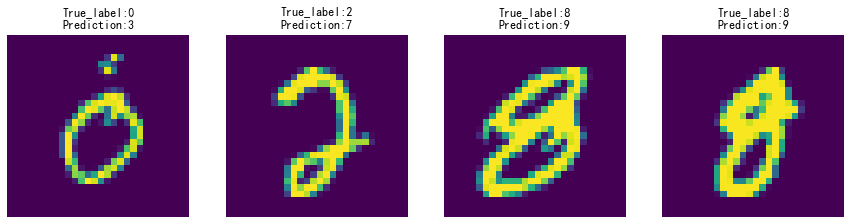

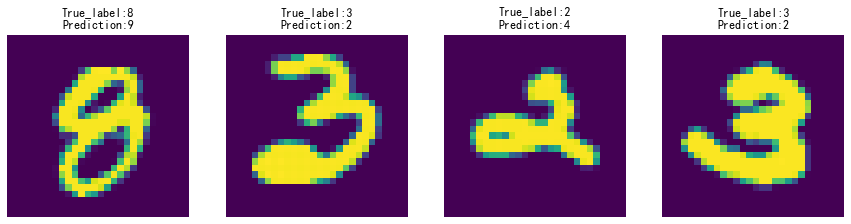

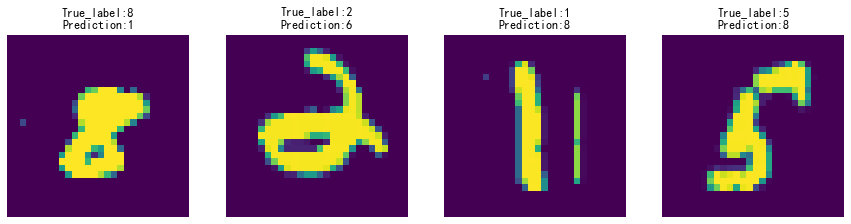

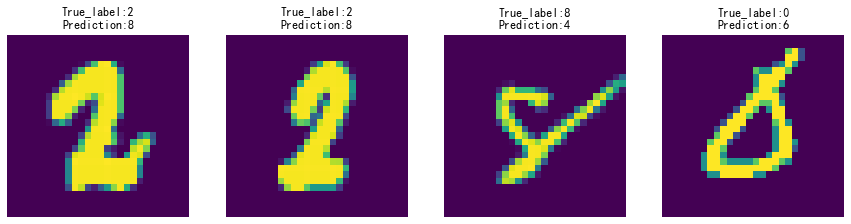

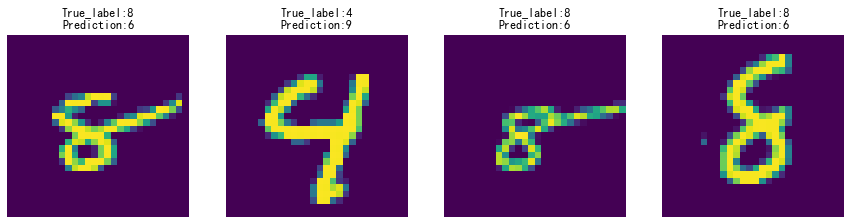

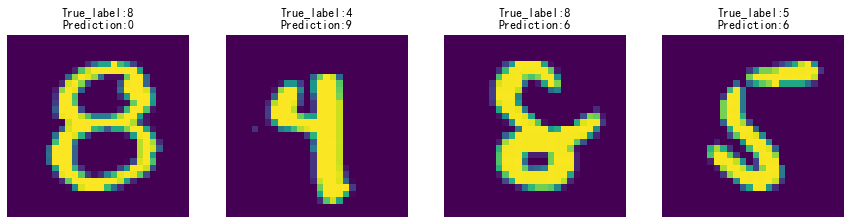

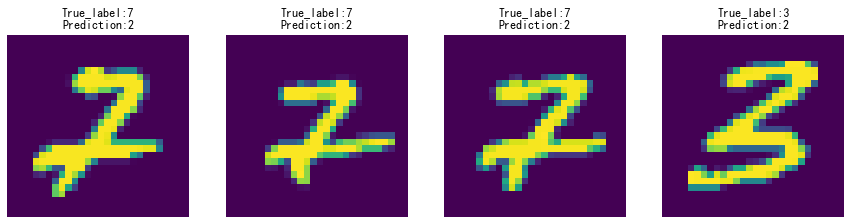

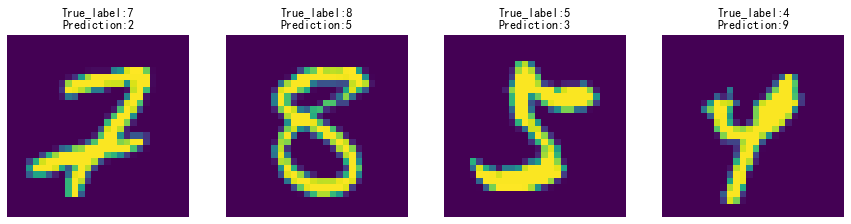

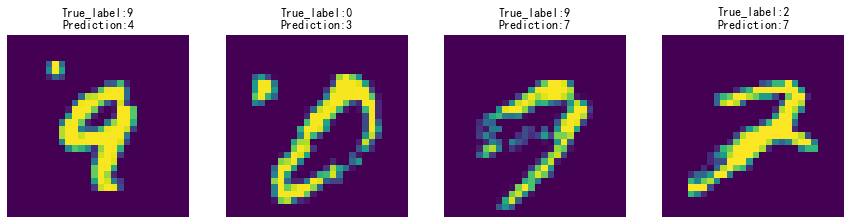

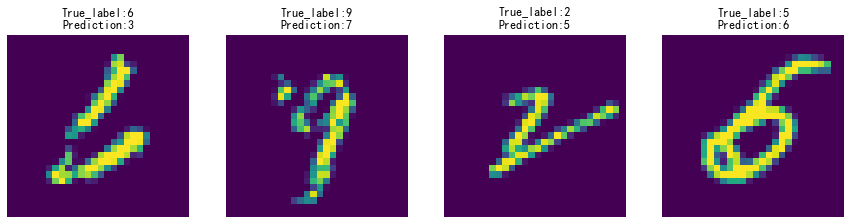

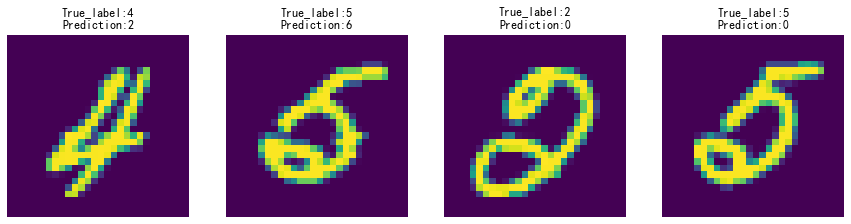

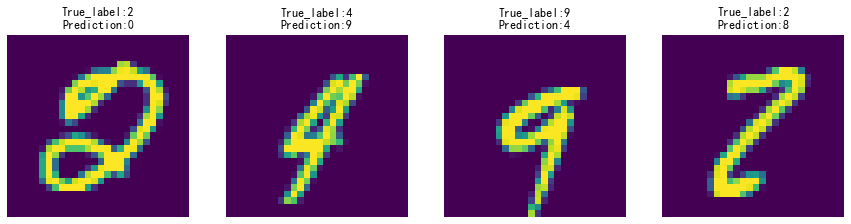

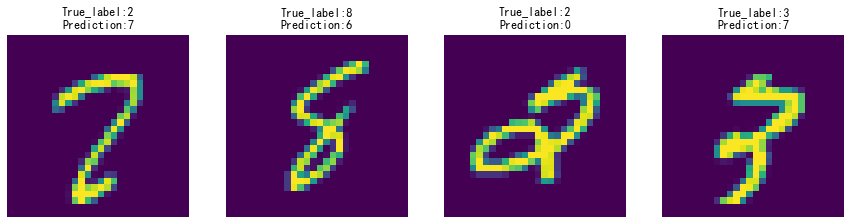

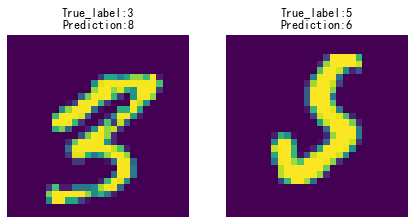

In [51]:
# 展示所有分类错误的图片，以及它们对应的标签和预测结果
for i in range(len(wrong_image_label)):
    plt.style.use({'figure.figsize':(15,15)}) # 设置图像大小
    plt.subplot(1,4,i%4+1) # 绘制一行四列的子图
    plt.imshow(wrong_image[i].reshape((28,28)).numpy()) # 绘制被分类错误的图片
    title = 'True_label:{}\nPrediction:{}'.format(wrong_image_label[i],wrong_image_pred[i]) # 图表标题说明图片的正确标签和错误结果
    plt.title(title)
    plt.xticks([]) # 关闭刻度线显示
    plt.yticks([])
    plt.axis('off') # 关闭坐标轴显示
    if i%4 == 3: # 凑够一行四个图就显示出来
        plt.show()

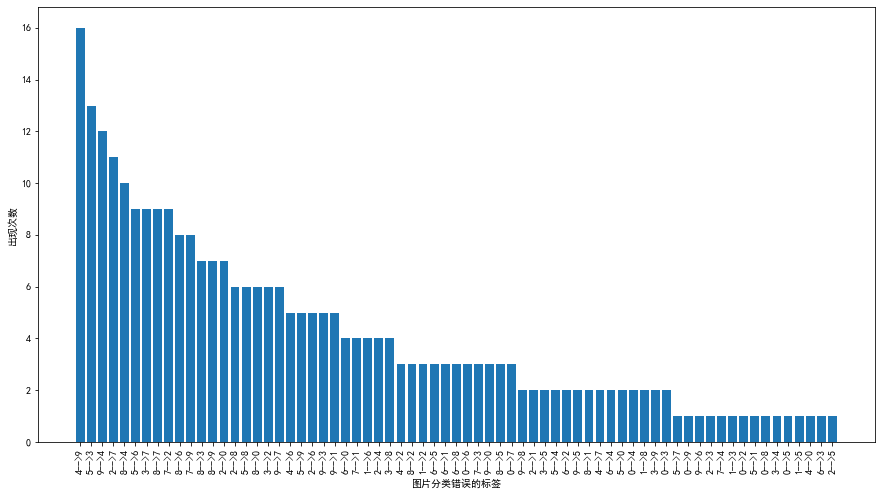

In [52]:
# 分析分类错误的图片，按出现次数降序排列画柱状图

# 构建字典存放分类错误图片的原始标签和预测标签
wrong_pair = dict()
for i in range(len(wrong_image_label)):
    word = f'{wrong_image_label[i]}-->{wrong_image_pred[i]}'
    wrong_pair[word] = wrong_pair.get(word,0) + 1

# 按照分类错误的出现次数排序
items = list(wrong_pair.items())
items.sort(key=lambda x:x[1], reverse=True) 

# 存成csv文件
import csv
with open("wrong_pair.csv","w") as csvfile: 
    writer = csv.writer(csvfile)
    #写入列名
    writer.writerow(["wrong_pair",'counts'])
    for each in items:
        new_row = [each[0],each[1]]
        #写入一行新数据
        writer.writerows([new_row])

import pandas as pd
df = pd.read_csv('wrong_pair.csv')

# 绘制柱状图
plt.style.use({'figure.figsize':(15,8)})
plt.bar(df['wrong_pair'],df['counts'])
plt.xticks(rotation=90)
plt.xlabel('图片分类错误的标签')
plt.ylabel('出现次数')
plt.show()

# 查看所有真实为4但被错分类为9的图片

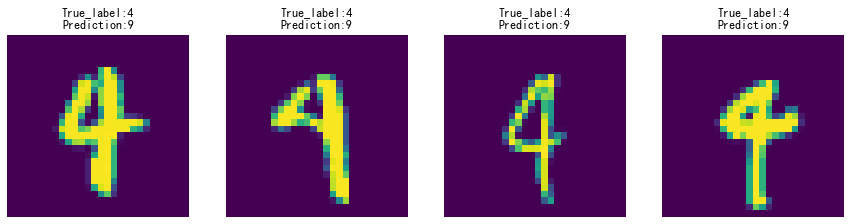

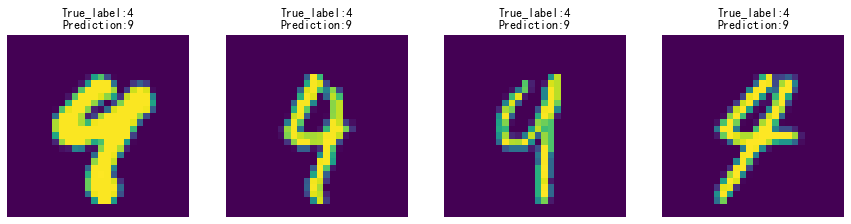

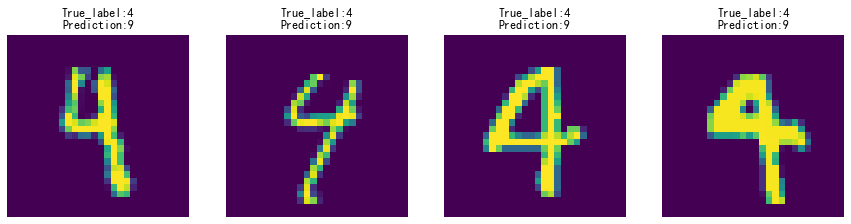

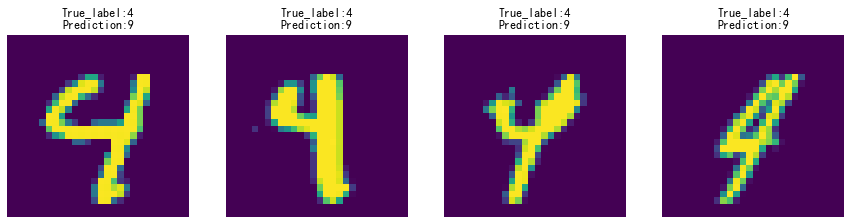

In [53]:
# 比如我们想查看所有真实为4但是被错分类为9的图片
true_label = 4
wrong_label = 9
i = 0
for j in range(len(wrong_image_pred)):
    if wrong_image_label[j] == true_label and wrong_image_pred[j] == wrong_label:
        plt.style.use({'figure.figsize':(15,15)}) # 设置图像大小
        plt.subplot(1,4,i%4+1) # 绘制一行四列的子图
        plt.imshow(wrong_image[j].reshape((28,28)).numpy()) # 绘制被分类错误的图片
        title = 'True_label:{}\nPrediction:{}'.format(true_label,wrong_label) # 图表标题说明图片的正确标签和错误结果
        plt.title(title)
        plt.xticks([]) # 关闭刻度线显示
        plt.yticks([])
        plt.axis('off') # 关闭坐标轴显示
        i += 1
        if i%4 == 0: # 凑够一行四个图就显示出来
            plt.show()

# 查看所有真实为7但被错分类为9的图片

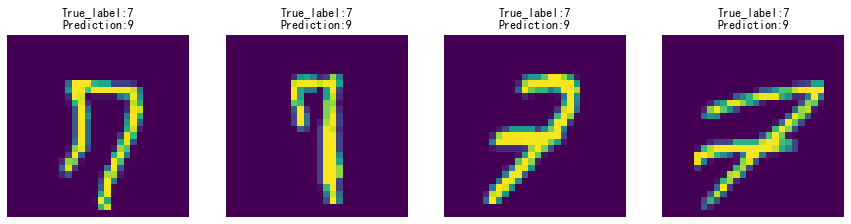

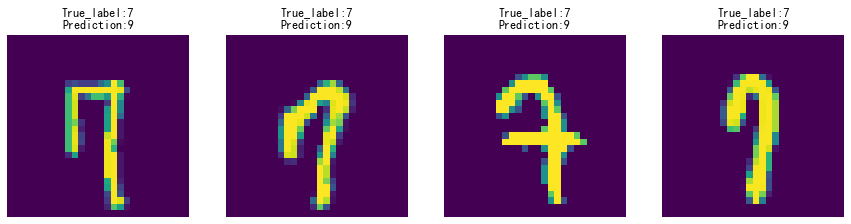

In [54]:
# 比如我们想查看所有真实为7但是被错分类为9的图片
true_label = 7
wrong_label = 9
i = 0
for j in range(len(wrong_image_pred)):
    if wrong_image_label[j] == true_label and wrong_image_pred[j] == wrong_label:
        plt.style.use({'figure.figsize':(15,15)}) # 设置图像大小
        plt.subplot(1,4,i%4+1) # 绘制一行四列的子图
        plt.imshow(wrong_image[j].reshape((28,28)).numpy()) # 绘制被分类错误的图片
        title = 'True_label:{}\nPrediction:{}'.format(true_label,wrong_label) # 图表标题说明图片的正确标签和错误结果
        plt.title(title)
        plt.xticks([]) # 关闭刻度线显示
        plt.yticks([])
        plt.axis('off') # 关闭坐标轴显示
        i += 1
        if i%4 == 0: # 凑够一行四个图就显示出来
            plt.show()